# Summarization (PyTorch)

In this section we’ll take a look at how Transformer models can be used to condense long documents into summaries, a task known as **text summarization**.

This is one of the most challenging NLP tasks as it requires a range of abilities, such as understanding long passages and generating coherent text that captures the main topics in a document. However, when done well, text summarization is a powerful tool that can speed up various business processes by relieving the burden of domain experts to read long documents in detail.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Preparing a multilingual corpus
We’ll use the [Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) to create our bilingual summarizer. This corpus consists of Amazon product reviews in six languages and is typically used to benchmark multilingual classifiers.

However, since each review is accompanied by a short title, we can use the titles as the target summaries for our model to learn from! To get started, let’s download the English and Spanish subsets from the Hugging Face Hub:


In [ ]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)

'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can\'t beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

In [ ]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: product_category, dtype: int64

The most popular products in the English dataset are about household items, clothing, and wireless electronics.

To stick with the Amazon theme, though, let’s focus on summarizing book reviews — after all, this is what the company was founded on! We can see two product categories that fit the bill (*book and digital_ebook_purchase*), so let’s filter the datasets in both languages for just these products. As we saw in Chapter 5, the `Dataset.filter()` function allows us to slice a dataset very efficiently, so we can define a simple function to do this:

In [ ]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

In [ ]:
english_dataset.reset_format()

In [ ]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

'>> Title: I\'m dissapointed.'
'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I\'d at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I\'m dissapointed.'

'>> Title: Good art, good price, poor design'
'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it\'s less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar'

'>> Title: Helpful'
'>> Review: Nearly all the tips useful and. I consider myself an intermediate t

Okay, we can see that the reviews are not strictly about books and might refer to things like calendars and electronic applications such as OneNote.

Nevertheless, the domain seems about right to train a summarization model on.

Before we look at various models that are suitable for this task, we have one last bit of data preparation to do: combining the English and Spanish reviews as **a single DatasetDict object**. 🤗 Datasets provides a handy `concatenate_datasets()` function that (as the name suggests) will stack two Dataset objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [ ]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)

'>> Title: Easy to follow!!!!'
'>> Review: I loved The dash diet weight loss Solution. Never hungry. I would recommend this diet. Also the menus are well rounded. Try it. Has lots of the information need thanks.'

'>> Title: PARCIALMENTE DAÑADO'
'>> Review: Me llegó el día que tocaba, junto a otros libros que pedí, pero la caja llegó en mal estado lo cual dañó las esquinas de los libros porque venían sin protección (forro).'

'>> Title: no lo he podido descargar'
'>> Review: igual que el anterior'

In [ ]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

# Models for text summarization
If you think about it, text summarization is a similar sort of task to machine translation: we have a body of text like a review that we’d like to “translate” into a shorter version that captures the salient features of the input.

Accordingly, most Transformer models for summarization adopt the encoder-decoder architecture that we first encountered in Chapter 1, although there are some exceptions like the GPT family of models which can also be used for summarization in few-shot settings. The following table lists some popular pretrained models that can be fine-tuned for summarization.

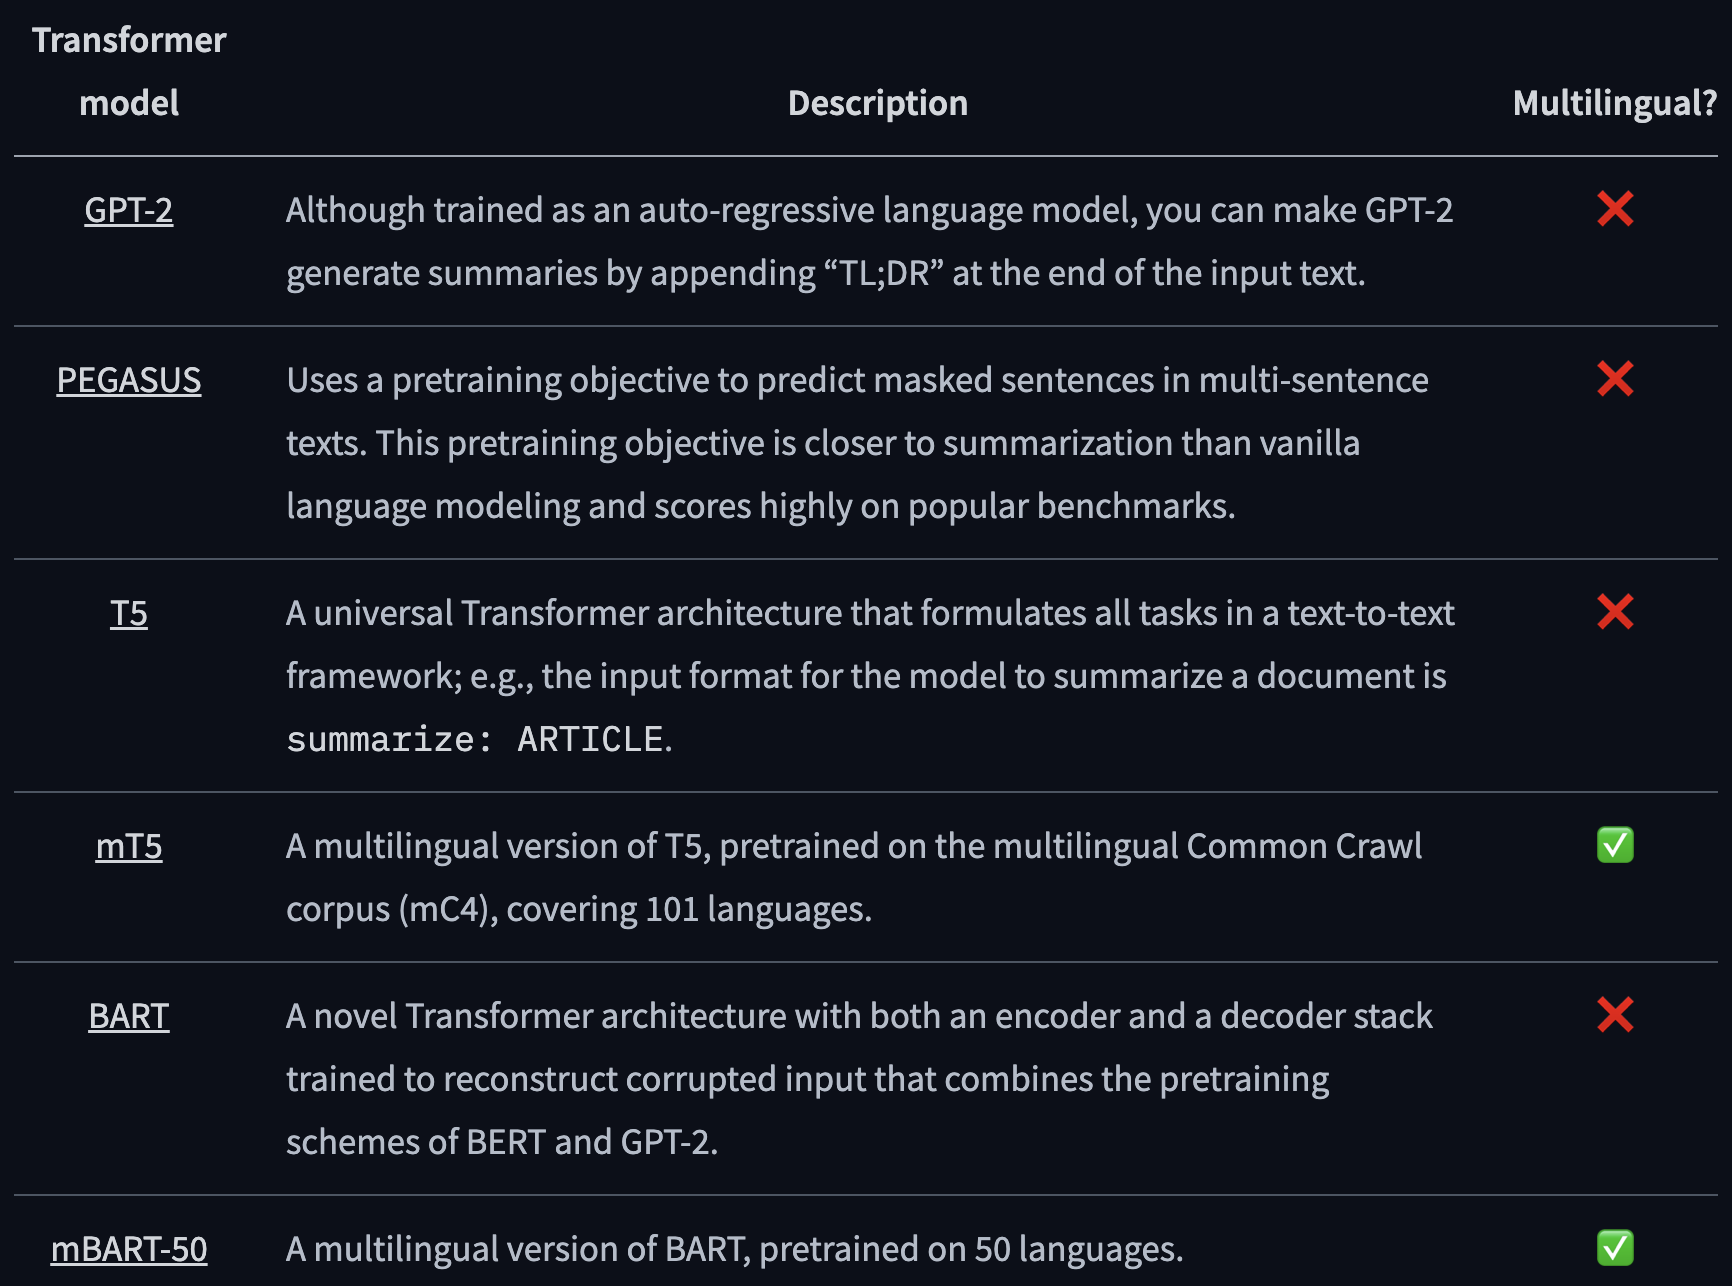

We’ll focus on `mT5`, an interesting architecture based on T5 that was pretrained in a text-to-text framework. In T5, every NLP task is formulated in terms of a prompt prefix like summarize: which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!

# Preprocessing the data

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '</s>']

The special Unicode character `▁` and end-of-sequence token `</s> `indicate that we’re dealing with the `SentencePiece tokenizer`, which is based on the *Unigram segmentation algorithm* discussed in Chapter 6.

Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.

To tokenize our corpus, we have to deal with a subtlety associated with summarization: because our labels are also text, it is possible that they exceed the model’s maximum context size. This means we need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model. The tokenizers in 🤗 Transformers provide a nifty `text_target` argument that allows you to tokenize the labels in parallel to the inputs. Here is an example of how the inputs and targets are processed for mT5:

In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

# Metrics
In comparison to most of the other tasks we’ve covered in this course, measuring the performance of text generation tasks like summarization or translation is not as straightforward.

For example, given a review like “I loved reading the Hunger Games”, there are multiple valid summaries, like “I loved the Hunger Games” or “Hunger Games is a great read”. Clearly, applying some sort of exact match between the generated summary and the label is not a good solution — even humans would fare poorly under such a metric, because we all have our own writing style.


For summarization, one of the most commonly used metrics is the `ROUGE score` (short for *Recall-Oriented Understudy for Gisting Evaluation*).


- The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans. To make this more precise, suppose we want to compare the following two summaries:

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [ ]:
!pip install rouge_score

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': AggregateScore(low=Score(precision=0.86, recall=1.0, fmeasure=0.92), mid=Score(precision=0.86, recall=1.0, fmeasure=0.92), high=Score(precision=0.86, recall=1.0, fmeasure=0.92)),
 'rouge2': AggregateScore(low=Score(precision=0.67, recall=0.8, fmeasure=0.73), mid=Score(precision=0.67, recall=0.8, fmeasure=0.73), high=Score(precision=0.67, recall=0.8, fmeasure=0.73)),
 'rougeL': AggregateScore(low=Score(precision=0.86, recall=1.0, fmeasure=0.92), mid=Score(precision=0.86, recall=1.0, fmeasure=0.92), high=Score(precision=0.86, recall=1.0, fmeasure=0.92)),
 'rougeLsum': AggregateScore(low=Score(precision=0.86, recall=1.0, fmeasure=0.92), mid=Score(precision=0.86, recall=1.0, fmeasure=0.92), high=Score(precision=0.86, recall=1.0, fmeasure=0.92))}

Whoa, there’s a lot of information in that output — what does it all mean?

- First, 🤗 Datasets actually computes confidence intervals for precision, recall, and F1-score; these are the `low, mid, and high` attributes you can see here.
- Moreover, 🤗 Datasets computes a variety of ROUGE scores which are based on different types of text granularity when comparing the generated and reference summaries.

The `rouge1` variant is the overlap of **unigrams** — this is just a fancy way of saying the overlap of words and is exactly the metric we’ve discussed above. To verify this, let’s pull out the mid value of our scores:

In [ ]:
scores["rouge1"].mid

Score(precision=0.86, recall=1.0, fmeasure=0.92)

Great, the precision and recall numbers match up!

Now what about those other ROUGE scores?
- `rouge2` measures the overlap between bigrams (think the overlap of pairs of words), while `rougeL` and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries.

The `“sum”` in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.



## Creating a strong baseline
A common baseline for text summarization is to simply take the first three sentences of an article, often called the `lead-3 baseline`.

We could use full stops to track the sentence boundaries, but this will fail on acronyms like “U.S.” or “U.N.” — so instead we’ll use the `nltk `library, which includes a better algorithm to handle these cases. You can install the package using pip as follows:


In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

'I grew up reading Koontz, and years ago, I stopped,convinced i had "outgrown" him.'
'Still,when a friend was looking for something suspenseful too read, I suggested Koontz.'
'She found Strangers.'

This seems to work, so let’s now implement a function that extracts these “summaries” from a dataset and computes the **ROUGE scores for the baseline**:

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [ ]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 16.74, 'rouge2': 8.83, 'rougeL': 15.6, 'rougeLsum': 15.96}

# Fine-tuning mT5 with the Trainer API
Fine-tuning a model for summarization is very similar to the other tasks we’ve covered in this chapter.
- The first thing we need to do is load the pretrained model from the mt5-small checkpoint. Since summarization is *a sequence-to-sequence task*, we can load the model with the `AutoModelForSeq2SeqLM` class, which will automatically download and cache the weights:

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

Here, the `predict_with_generate` argument has been set to indicate that we should generate summaries during evaluation so that we can compute ROUGE scores for each epoch. As discussed in Chapter 1, the decoder performs inference by predicting tokens one by one, and this is implemented by the model’s `generate()` method. Setting `predict_with_generate=True` tells the `Seq2SeqTrainer` to use that method for evaluation. We’ve also adjusted some of the default hyperparameters, like the learning rate, number of epochs, and weight decay, and we’ve set the `save_total_limit` option to only save up to 3 checkpoints during training — this is because even the “small” version of mT5 uses around a GB of hard drive space, and we can save a bit of room by limiting the number of copies we save.

The `push_to_hub=True` argument will allow us to push the model to the Hub after training; you’ll find the repository under your user profile in the location defined by output_dir. Note that you can specify the name of the repository you want to push to with the hub_model_id argument (in particular, you will have to use this argument to push to an organization). For instance, when we pushed the model to the huggingface-course organization, we added `hub_model_id="huggingface-course/mt5-finetuned-amazon-en-es"` to `Seq2SeqTrainingArguments`.

The next thing we need to do is provide the trainer with a `compute_metrics()` function so that we can evaluate our model during training. For summarization this is a bit more involved than simply calling `rouge_score.compute()` on the model’s predictions, since we need to decode the outputs and labels into text before we can compute the ROUGE scores. The following function does exactly that, and also makes use of the `sent_tokenize()` function from nltk to separate the summary sentences with newlines:

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

- Next, we need to define *a data collator* for our sequence-to-sequence task. Since mT5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one.

This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. This is similar to how masked self-attention is applied to the inputs in a task like causal language modeling.

Luckily, 🤗 Transformers provides a `DataCollatorForSeq2Seq` collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'input_ids': tensor([[  1494,    259,   8622,    390,    259,    262,   2316,   3435,    955,
            772,    281,    772,   1617,    263,    305,  14701,    260,   1385,
           3031,    259,  24146,    332,   1037,    259,  43906,    305,    336,
            260,      1,      0,      0,      0,      0,      0,      0],
        [   259,  27531,  13483,    259,   7505,    260, 112240,  15192,    305,
          53198,    276,    259,  74060,    263,    260,    459,  25640,    776,
           2119,    336,    259,   2220,    259,  18896,    288,   4906,    288,
           1037,   3931,    260,   7083, 101476,   1143,    260,      1]]), 'labels': tensor([[ 7483,   259,  2364, 15695,     1,  -100],
        [  259, 2753

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

{'eval_loss': 3.028524398803711,
 'eval_rouge1': 16.9728,
 'eval_rouge2': 8.2969,
 'eval_rougeL': 16.8366,
 'eval_rougeLsum': 16.851,
 'eval_gen_len': 10.1597,
 'eval_runtime': 6.1054,
 'eval_samples_per_second': 38.982,
 'eval_steps_per_second': 4.914}

# Fine-tuning mT5 with 🤗 Accelerate
Fine-tuning our model with 🤗 Accelerate is very similar to the text classification example we encountered in Chapter 3. The main differences will be the need to explicitly generate our summaries during training and define how we compute the ROUGE scores (recall that the Seq2SeqTrainer took care of the generation for us). Let’s take a look how we can implement these two requirements within 🤗 Accelerate!

In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'lewtun/mt5-finetuned-amazon-en-es-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

## Training loop
The training loop for summarization is quite similar to the other 🤗 Accelerate examples that we’ve encountered and is roughly split into four main steps:

1. Train the model by iterating over all the examples in train_dataloader for each epoch.
2. Generate model summaries at the end of each epoch, by first generating the tokens and then decoding them (and the reference summaries) into text.
3. Compute the ROUGE scores using the same techniques we saw earlier.
4. Save the checkpoints and push everything to the Hub. Here we rely on the nifty blocking=False argument of the Repository object so that we can push the checkpoints per epoch asynchronously. This allows us to continue training without having to wait for the somewhat slow upload associated with a GB-sized model!

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

Epoch 0: {'rouge1': 5.6351, 'rouge2': 1.1625, 'rougeL': 5.4866, 'rougeLsum': 5.5005}
Epoch 1: {'rouge1': 9.8646, 'rouge2': 3.4106, 'rougeL': 9.9439, 'rougeLsum': 9.9306}
Epoch 2: {'rouge1': 11.0872, 'rouge2': 3.3273, 'rougeL': 11.0508, 'rougeLsum': 10.9468}
Epoch 3: {'rouge1': 11.8587, 'rouge2': 4.8167, 'rougeL': 11.7986, 'rougeLsum': 11.7518}
Epoch 4: {'rouge1': 12.9842, 'rouge2': 5.5887, 'rougeL': 12.7546, 'rougeLsum': 12.7029}
Epoch 5: {'rouge1': 13.4628, 'rouge2': 6.4598, 'rougeL': 13.312, 'rougeLsum': 13.2913}
Epoch 6: {'rouge1': 12.9131, 'rouge2': 5.8914, 'rougeL': 12.6896, 'rougeLsum': 12.5701}
Epoch 7: {'rouge1': 13.3079, 'rouge2': 6.2994, 'rougeL': 13.1536, 'rougeLsum': 13.1194}
Epoch 8: {'rouge1': 13.96, 'rouge2': 6.5998, 'rougeL': 13.9123, 'rougeLsum': 13.7744}
Epoch 9: {'rouge1': 14.1192, 'rouge2': 7.0059, 'rougeL': 14.1172, 'rougeLsum': 13.9509}

# Using your fine-tuned model
Once you’ve pushed the model to the Hub, you can play with it either via the inference widget or with a pipeline object, as follows:

In [ ]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [ ]:
print_summary(100)

'>>> Review: Nothing special at all about this product... the book is too small and stiff and hard to write in. The huge sticker on the back doesn’t come off and looks super tacky. I would not purchase this again. I could have just bought a journal from the dollar store and it would be basically the same thing. It’s also really expensive for what it is.'

'>>> Title: Not impressed at all... buy something else'

'>>> Summary: Nothing special at all about this product'

In [ ]:
print_summary(0)

'>>> Review: Es una trilogia que se hace muy facil de leer. Me ha gustado, no me esperaba el final para nada'

'>>> Title: Buena literatura para adolescentes'

'>>> Summary: Muy facil de leer'